In [14]:
# %load ./pre_process.py
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import model_selection

from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from time import perf_counter

from pycm import ConfusionMatrix, Compare

import re


def experiment(model, X, Y, alg_title, files, report = True):
    
    t_start = perf_counter()
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

    model.fit(X_train, Y_train)

    Y_pred = model.predict(X_test)
    
    t_stop = perf_counter()
    
    elapsed_time = t_stop - t_start

    cm = ConfusionMatrix(actual_vector = Y_test, predict_vector = Y_pred)

    if report:
        print(alg_title)
        print(classification_report(Y_test, Y_pred))

        cm.plot(cmap = plt.cm.Greens, number_label = True, title = alg_title, plot_lib = 'matplotlib')
        file_name = re.sub('[\s+]', '', files + '_' + alg_title + '_cm.png')
        plt.savefig(file_name)
        plt.show()
    
    return {
        'elapsed_time': elapsed_time,
        'test': Y_test,
        'pred': Y_pred,
        'cm': cm,
        'title': alg_title,
    }

def run_pre_process(data):
    
    data.groupby('defects')['b'].apply(lambda x: x.count())

    sns.histplot(data = data, x = 'defects')
    plt.tight_layout()
    plt.show()
    
    data.corr()

    f, ax = plt.subplots(figsize = (15, 15))
    sns.heatmap(data.corr(), annot = True, linewidths = .5, fmt = '.2f')
    plt.show()

    sns.scatterplot(data = data, x = 'v', y = 'b')
    plt.show()

    sns.boxplot(data = data, x = 'uniq_Op')
    plt.show()

    from sklearn import preprocessing

    scale_v = data[['v']]
    scale_b = data[['b']]

    minmax_scaler = preprocessing.MinMaxScaler()

    v_scaled = minmax_scaler.fit_transform(scale_v)
    b_scaled = minmax_scaler.fit_transform(scale_b)

    data['v_ScaledUp'] = pd.DataFrame(v_scaled)
    data['b_ScaledUp'] = pd.DataFrame(b_scaled)

    data

    X = data.iloc[:, :-10].values
    Y = data.defects.values

    validation_size = 0.20
    seed = 7
    X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size = validation_size, random_state = seed)

    return X, Y, X_train, Y_train, seed

def result_analysis(results, files):

    elapsed_times = [ t['elapsed_time'] for t in results ]
    labels = [ l['title'] for l in results ]

    x = np.arange(len(elapsed_times))
    width = .35
    fig, ax = plt.subplots()
    rects_elapsed_times = ax.barh(x, elapsed_times, width, label='Tempos de execução (em segs)')
    ax.set_xlabel('Tempos')
    ax.set_title('Tempos por algorítimo')
    ax.set_yticks(x)
    ax.set_yticklabels(labels)
    ax.legend()
    fig.tight_layout()
    file_name = re.sub('[\s+]', '', files + '_elapsed_times.png')
    plt.savefig(file_name)
    plt.show()

    experiments = { e['title']: e['cm'] for e in results }

    print(Compare(experiments))

    for e in results:
        print(e['title'],'MCC:',e['cm'].MCC,'ACC:',e['cm'].ACC)

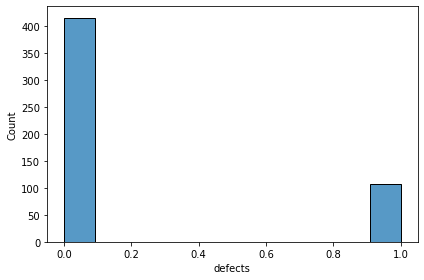

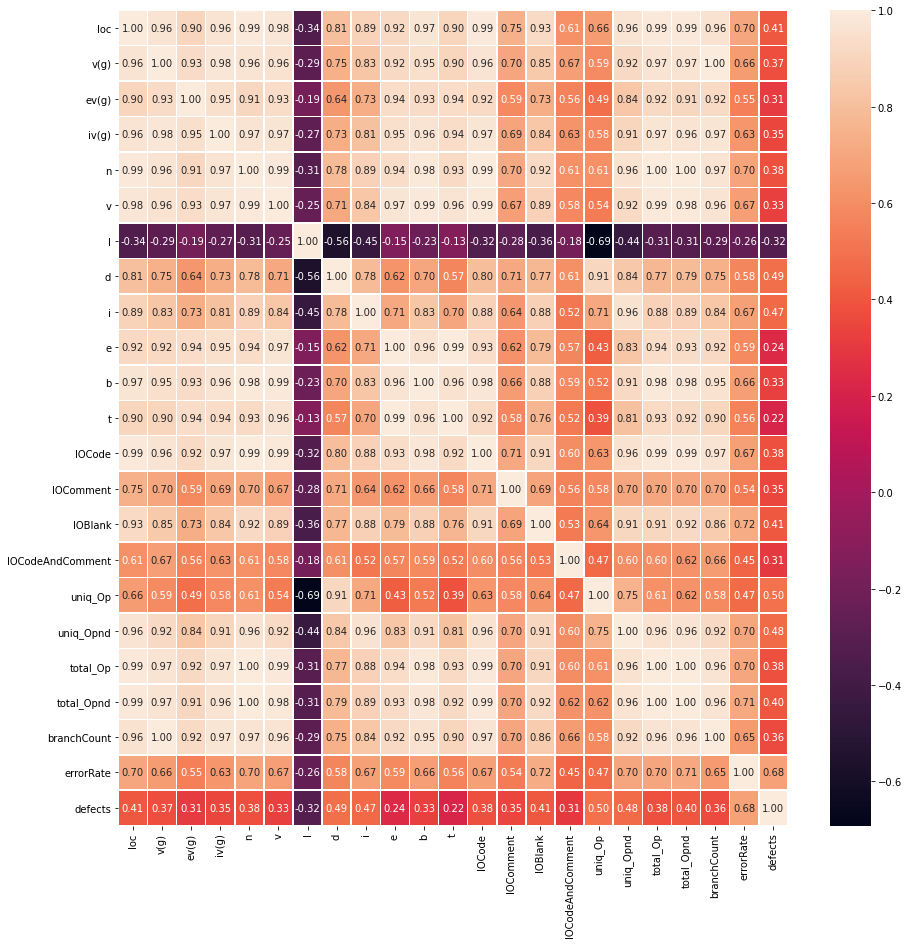

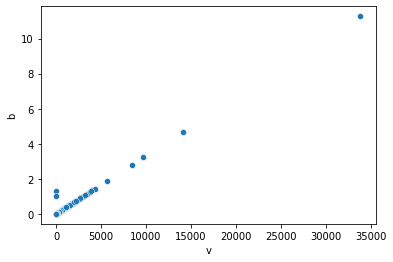

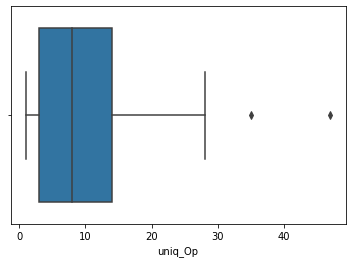

In [3]:
data = pd.read_csv('../_data/kc2.csv')
X, Y, X_train, Y_train, seed = run_pre_process(data)

In [4]:
results = [0] * 4

# Decision Tree

In [5]:
model = tree.DecisionTreeClassifier()

Decision Tree
              precision    recall  f1-score   support

           0       0.85      0.94      0.89        83
           1       0.62      0.36      0.46        22

    accuracy                           0.82       105
   macro avg       0.73      0.65      0.67       105
weighted avg       0.80      0.82      0.80       105



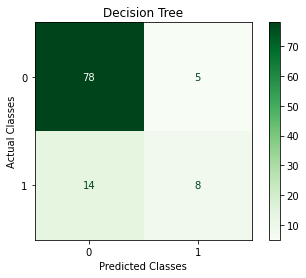

In [6]:
results[0] = experiment(model, X, Y, 'Decision Tree', files = 'KC2')

# Naïve Bayes

In [7]:
model = GaussianNB()

scoring = 'accuracy'
kfold = model_selection.KFold(n_splits = 10, random_state = seed, shuffle = True)
cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv = kfold, scoring = scoring)
print("Mean : %f - Std : (%f)" % (cv_results.mean(), cv_results.std()))

Mean : 0.851278 - Std : (0.050169)


Naïve Bayes
              precision    recall  f1-score   support

           0       0.84      0.95      0.89        83
           1       0.64      0.32      0.42        22

    accuracy                           0.82       105
   macro avg       0.74      0.63      0.66       105
weighted avg       0.80      0.82      0.79       105



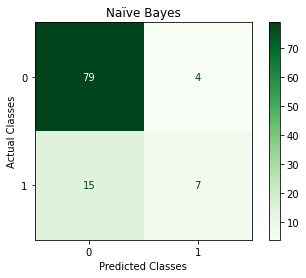

In [8]:
results[1] = experiment(model, X, Y, 'Naïve Bayes', files = 'KC2')

# Random Forest

In [9]:
model = RandomForestClassifier(n_estimators = 100)

Random Forest
              precision    recall  f1-score   support

           0       0.87      0.96      0.91        83
           1       0.77      0.45      0.57        22

    accuracy                           0.86       105
   macro avg       0.82      0.71      0.74       105
weighted avg       0.85      0.86      0.84       105



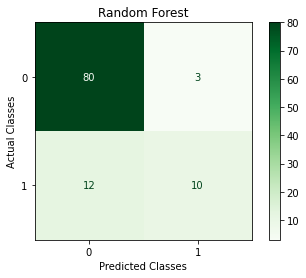

In [10]:
results[2] = experiment(model, X, Y, 'Random Forest', files = 'KC2')

# Support Vector Machine

In [11]:
model = svm.SVC(kernel = 'linear', C = 0.01)

Support Vector Machine
              precision    recall  f1-score   support

           0       0.87      0.95      0.91        83
           1       0.71      0.45      0.56        22

    accuracy                           0.85       105
   macro avg       0.79      0.70      0.73       105
weighted avg       0.84      0.85      0.83       105



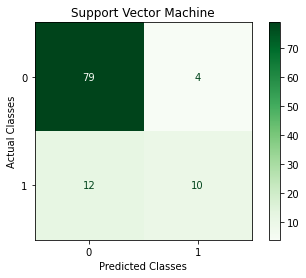

In [12]:
results[3] = experiment(model, X, Y, 'Support Vector Machine', files = 'KC2')

# Análise de Resultados

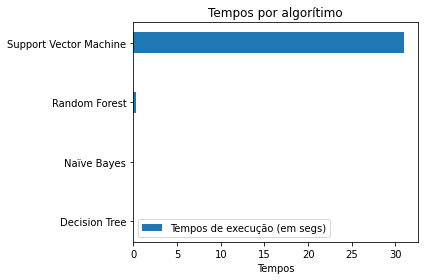

Best : Random Forest

Rank    Name                      Class-Score    Overall-Score
1       Random Forest             7.65           3.7
2       Support Vector Machine    6.75           3.5
3       Naïve Bayes               6.35           2.38333
3       Decision Tree             6.35           2.38333

Decision Tree MCC: {0: 0.3748813095095569, 1: 0.3748813095095569} ACC: {0: 0.819047619047619, 1: 0.819047619047619}
Naïve Bayes MCC: {0: 0.3587866402333297, 1: 0.3587866402333297} ACC: {0: 0.819047619047619, 1: 0.819047619047619}
Random Forest MCC: {0: 0.5169843329698582, 1: 0.5169843329698582} ACC: {0: 0.8571428571428571, 1: 0.8571428571428571}
Support Vector Machine MCC: {0: 0.48648427262381366, 1: 0.48648427262381366} ACC: {0: 0.8476190476190476, 1: 0.8476190476190476}


In [15]:
result_analysis(results, files = 'KC2')

> This is the end